# Partie 1 : Apprentissage supervisé
## `20newsgroups` **sans** stopwords
**Remarque** : les classifieurs KNN multi-classe, Perceptron sans biais, Naïf Bayes ont été optimisés pour les matrices creuses *(sparse array)* de ***scipy***

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
from unidecode import unidecode 
%matplotlib inline  

from matplotlib import cm # 3D

import time

import sys
sys.path.append('../') 

from iads import Classifiers as classif
from iads import utils as ut
from iads import evaluation as ev
from iads import Clustering as clust

# Vectorisation des docs avec BoW (binaire ou non), TfIdf
from iads.vectorization import get_bow_vect, get_tfidf_vect

# Prétraitement du text 
from iads.preprocessing import get_corpus, clean_news, lemmatize_filter



sns.set_theme()
plt.rcParams['font.family'] = 'Proxima Nova'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Chargement des données

In [31]:
newsgroups_df = pd.read_csv("data/sample.csv")
stop_words_df = pd.read_csv("data/stopwords.csv")
stopwords = stop_words_df["stopword"].values.tolist()

news_no_stopwords = clean_news(newsgroups_df, stopwords, True, True)
news_no_stopwords = lemmatize_filter(news_no_stopwords, 3, 10)
corpus = get_corpus(news_no_stopwords)
news_no_stopwords

Number of Nans 48


,Message index,target,label,messages
0,0,0,alt.atheism,law seem value criminal life victim life islam...
1,1,0,alt.atheism,com bill newsgroups alt atheism organization s...
2,2,0,alt.atheism,true believer die belief jesus jim jones well ...
3,3,0,alt.atheism,knowing keith expect bring better oil well dry
4,4,0,alt.atheism,film medium alternative movie source may book ...
...,...,...,...,...
1810,1879,19,comp.os.ms-windows.misc,think mistaken thinking tom atheist find athei...
1811,1881,19,comp.os.ms-windows.misc,would religious belief therefore feel comforta...
1812,1882,19,comp.os.ms-windows.misc,extremely good example evidence every time rig...
1813,1883,19,comp.os.ms-windows.misc,vol part ocean translation turkish writing sai...


##### Naïf Bayes

------ affichage validation croisée
Itération 0: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.3831
Itération 1: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.3521
Itération 2: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.3718
Itération 3: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.3465
Itération 4: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.3775
------ fin affichage validation croisée
Results [0.38309859154929576, 0.352112676056338, 0.37183098591549296, 0.3464788732394366, 0.37746478873239436]
Mean accuracy 0.3662, std : 0.0144
Time 1.1611168384552002


Text(0.5, 1.0, 'Confusion matrix')

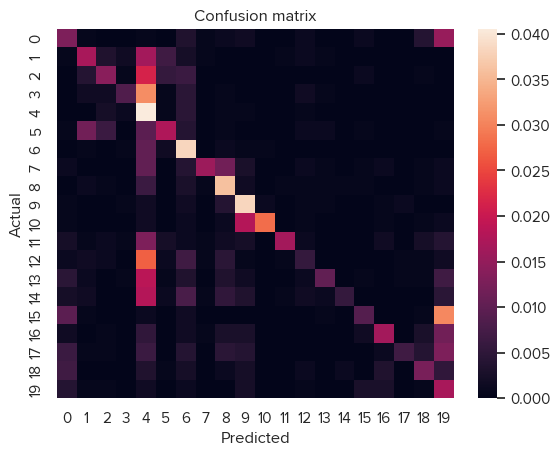

In [14]:
news_labels = news_no_stopwords["target"].values
# !Important! BoW non binaire
news_desc = get_bow_vect(news_no_stopwords, corpus, binary=False)

bayes = classif.NaiveBayes(news_desc.shape[1], corpus, np.unique(news_labels))

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(bayes, (news_desc, news_labels), 5, True, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

### Déterminer K pour KNN pour différents méthode de vectorisation

In [15]:
news_labels = news_no_stopwords["target"].values
n_classes = news_no_stopwords["target"].nunique()

news_desc_bow_bin = get_bow_vect(news_no_stopwords, corpus, True)
news_desc_bow_freq = get_bow_vect(news_no_stopwords, corpus, False)
news_desc_tfidf = get_tfidf_vect(news_no_stopwords, corpus)

1
3
5
7
9
11
13
15
17
19


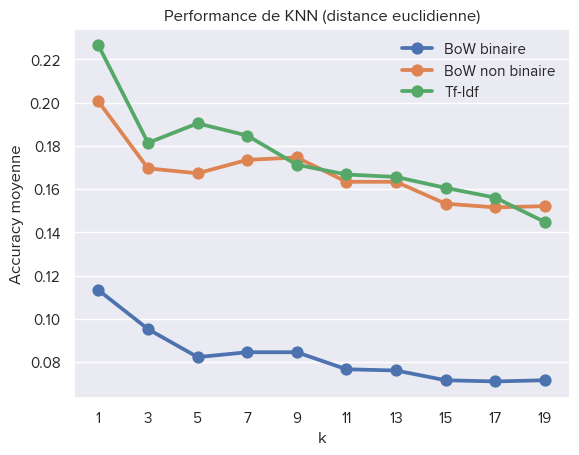

In [10]:
k_values, means = np.arange(1, 21, 2), []

for k in k_values:
    print(k)
    np.random.seed(1)
    classifier_knn = classif.ClassifierKNN_MC(news_desc.shape[1], k=k, C=n_classes, dist_type="euclidean")

    (_, mean_bow_bin, _) = ev.validation_croisee(classifier_knn, (news_desc_bow_bin, news_labels), 5, False, False)
    (_, mean_bow_freq, _) = ev.validation_croisee(classifier_knn, (news_desc_bow_freq, news_labels), 5, False, False)
    (_, mean_tfidf, _) = ev.validation_croisee(classifier_knn, (news_desc_tfidf, news_labels), 5, False, False)

    means.append([mean_bow_bin, mean_bow_freq, mean_tfidf])

data=pd.DataFrame(data={"k":k_values, "mean accuracy":means})
data[['BoW binaire', 'BoW non binaire', "Tf-Idf"]] = pd.DataFrame(data["mean accuracy"].to_list(),
                                                                  columns=['BoW binaire', 'BoW non binaire', "Tf-Idf"],
                                                                  index = data.index)
data = data.drop(columns="mean accuracy")
data = data.melt(id_vars="k", value_vars=['BoW binaire', 'BoW non binaire', "Tf-Idf"], var_name="vectorisation", value_name="Accuracy moyenne")

ax = sns.pointplot(data, x="k", y="Accuracy moyenne", hue="vectorisation")
ax.legend(frameon=False)
ax.set_title("Performance de KNN (distance euclidienne)")
plt.savefig("images/no_sw/knn_euclidean", dpi=150, bbox_inches="tight")

1
3
5
7
9
11
13
15
17
19


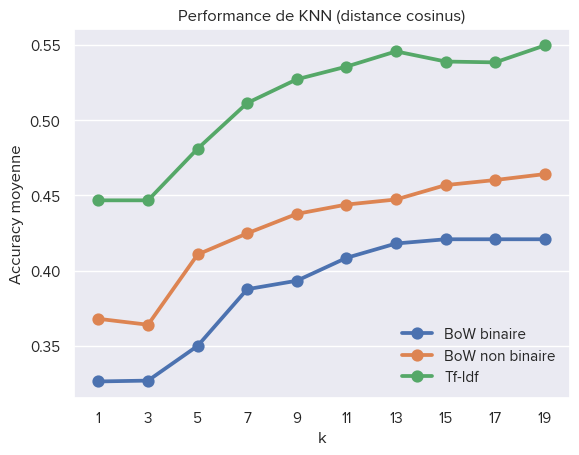

In [11]:
k_values, means = np.arange(1, 21, 2), []

for k in k_values:
    print(k)
    np.random.seed(1)
    classifier_knn = classif.ClassifierKNN_MC(news_desc.shape[1], k=k, C=n_classes, dist_type="cosine")

    (_, mean_bow_bin, _) = ev.validation_croisee(classifier_knn, (news_desc_bow_bin, news_labels), 5, False, False)
    (_, mean_bow_freq, _) = ev.validation_croisee(classifier_knn, (news_desc_bow_freq, news_labels), 5, False, False)
    (_, mean_tfidf, _) = ev.validation_croisee(classifier_knn, (news_desc_tfidf, news_labels), 5, False, False)

    means.append([mean_bow_bin, mean_bow_freq, mean_tfidf])

data=pd.DataFrame(data={"k":k_values, "mean accuracy":means})
data[['BoW binaire', 'BoW non binaire', "Tf-Idf"]] = pd.DataFrame(data["mean accuracy"].to_list(),
                                                                  columns=['BoW binaire', 'BoW non binaire', "Tf-Idf"],
                                                                  index = data.index)
data = data.drop(columns="mean accuracy")
data = data.melt(id_vars="k", value_vars=['BoW binaire', 'BoW non binaire', "Tf-Idf"], var_name="vectorisation", value_name="Accuracy moyenne")

ax = sns.pointplot(data, x="k", y="Accuracy moyenne", hue="vectorisation")
ax.legend(frameon=False)
ax.set_title("Performance de KNN (distance cosinus)")
plt.savefig("images/no_sw/knn_cosine", dpi=150, bbox_inches="tight")

#### **Bag-of-words binaire**

In [16]:
news_labels = news_no_stopwords["target"].values
n_classes = news_no_stopwords["target"].nunique()

# BoW binaire
news_desc = get_bow_vect(news_no_stopwords, corpus, binary=True)
news_desc.shape

(1815, 3284)

##### KNN multi-classe [distance **euclidienne**] k = 1

Results [0.23943661971830985, 0.21971830985915494, 0.2676056338028169, 0.2056338028169014, 0.2]
Mean accuracy 0.2265, std : 0.0247
Time 1.1322717666625977


Text(0.5, 1.0, 'Confusion matrix')

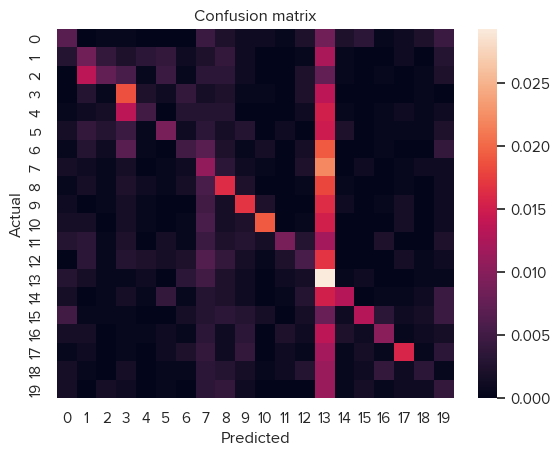

In [32]:

np.random.seed(1)
classifier_knn = classif.ClassifierKNN_MC(news_desc.shape[1], k=1, C=n_classes, dist_type="euclidean")

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(classifier_knn, (news_desc, news_labels), 5, False, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

##### KNN multi-classe [distance **cosinus**] k = 13

Results [0.4422535211267606, 0.4112676056338028, 0.4253521126760563, 0.37746478873239436, 0.43380281690140843]
Mean accuracy 0.4180, std : 0.0227
Time 1.7251899242401123


Text(0.5, 1.0, 'Confusion matrix')

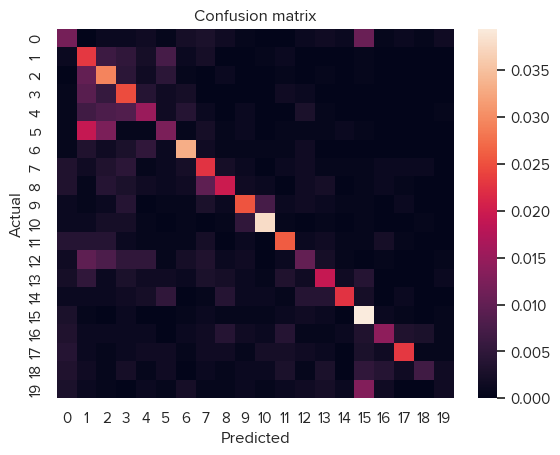

In [18]:
np.random.seed(1)
classifier_knn = classif.ClassifierKNN_MC(news_desc.shape[1], k=13, C=n_classes, dist_type="cosine")

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(classifier_knn, (news_desc, news_labels), 5, False, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

##### Perceptron

------ affichage validation croisée
Itération 0: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.4845
Itération 1: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.4563
Itération 2: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.5127
Itération 3: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.4620
Itération 4: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.4704
------ fin affichage validation croisée
Results [0.48450704225352115, 0.4563380281690141, 0.5126760563380282, 0.4619718309859155, 0.4704225352112676]
Mean accuracy 0.4772, std : 0.0201
Time 69.88285684585571


Text(0.5, 1.0, 'Confusion matrix')

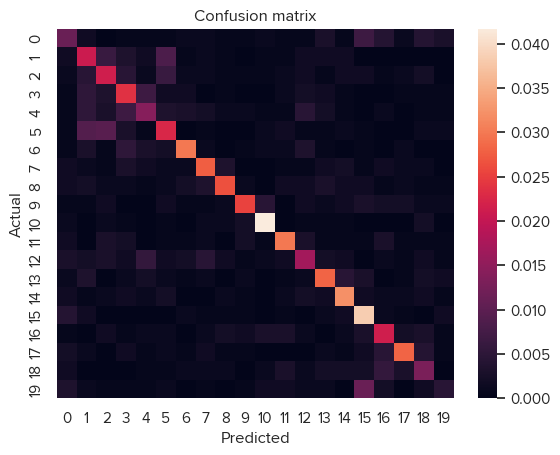

In [19]:
np.random.seed(1)
classifier_perc = classif.ClassifierPerceptron(news_desc.shape[1], 0.01, init=False)
perc_mcc = classif.ClassifierMultiOAA(classifier_perc, classes = np.unique(news_labels))

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(perc_mcc, (news_desc, news_labels), 5, True, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

##### Arbre de décision

------ affichage validation croisée
Itération 0: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.2873
Itération 1: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.3155
Itération 2: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.3014
Itération 3: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.2648
Itération 4: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.2732
------ fin affichage validation croisée
Results [0.28732394366197184, 0.3154929577464789, 0.30140845070422534, 0.2647887323943662, 0.27323943661971833]
Mean accuracy 0.2885, std : 0.0184
Time 341.7474136352539


Text(0.5, 1.0, 'Confusion matrix')

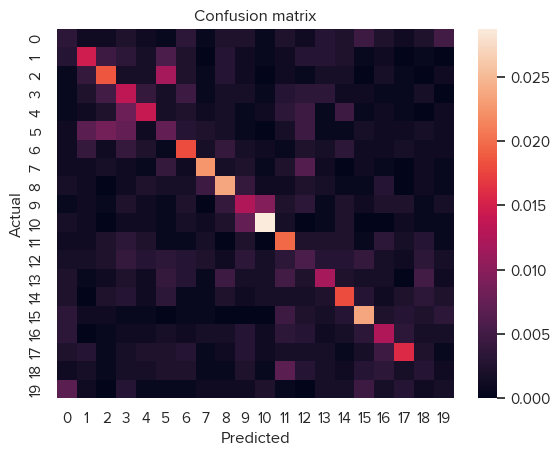

In [20]:
np.random.seed(1)
tree_decision = classif.ClassifierArbreDecision(news_desc.shape[1], epsilon=0.0)

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(tree_decision, (news_desc.toarray(), news_labels), 5, True, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

#### **Bag-of-words avec fréquence**

In [21]:
news_labels = news_no_stopwords["target"].values
n_classes = news_no_stopwords["target"].nunique()

# BoW non binaire
news_desc = get_bow_vect(news_no_stopwords, corpus, binary=False)
news_desc.shape

(1815, 3284)

##### KNN multi-classe [distance **euclidienne**] k = 1

Results [0.19436619718309858, 0.21690140845070421, 0.21690140845070421, 0.19436619718309858, 0.18028169014084508]
Mean accuracy 0.2006, std : 0.0143
Time 1.6110360622406006


Text(0.5, 1.0, 'Confusion matrix')

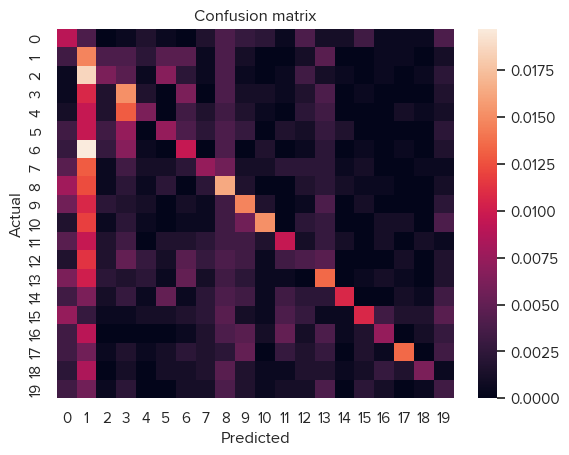

In [22]:
np.random.seed(1)
classifier_knn = classif.ClassifierKNN_MC(news_desc.shape[1], k=1, C=n_classes, dist_type="euclidean")

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(classifier_knn, (news_desc, news_labels), 5, False, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

##### KNN multi-classe [distance **cosinus**] k = 13

Results [0.4619718309859155, 0.4309859154929577, 0.4140845070422535, 0.4507042253521127, 0.4788732394366197]
Mean accuracy 0.4473, std : 0.0228
Time 1.9655959606170654


Text(0.5, 1.0, 'Confusion matrix')

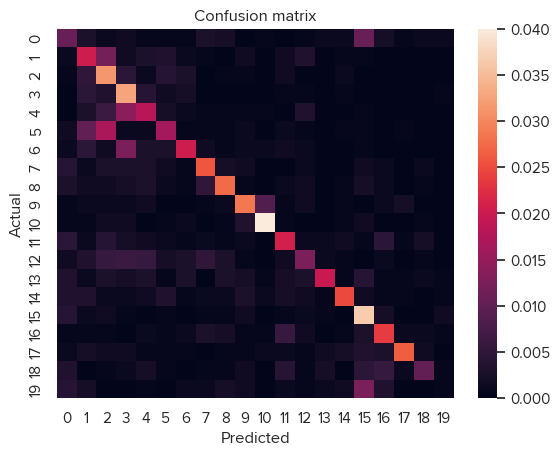

In [23]:
np.random.seed(1)
classifier_knn = classif.ClassifierKNN_MC(news_desc.shape[1], k=13, C=n_classes, dist_type="cosine")

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(classifier_knn, (news_desc, news_labels), 5, False, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

##### Perceptron

------ affichage validation croisée
Itération 0: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.4592
Itération 1: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.4366
Itération 2: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.4845
Itération 3: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.4873
Itération 4: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.4845
------ fin affichage validation croisée
Results [0.4591549295774648, 0.43661971830985913, 0.48450704225352115, 0.48732394366197185, 0.48450704225352115]
Mean accuracy 0.4704, std : 0.0198
Time 101.80515623092651


Text(0.5, 1.0, 'Confusion matrix')

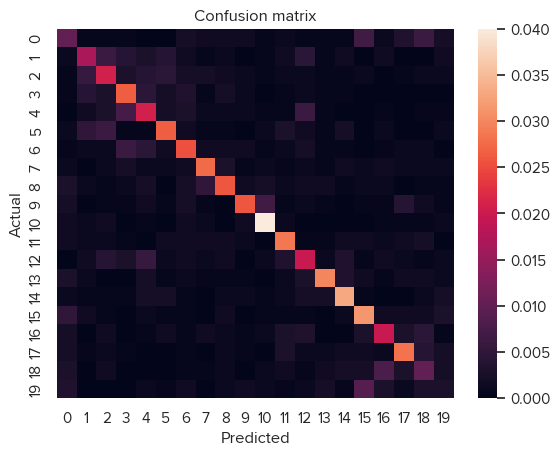

In [24]:
np.random.seed(1)
classifier_perc = classif.ClassifierPerceptron(news_desc.shape[1], 0.01, init=False)
perc_mcc = classif.ClassifierMultiOAA(classifier_perc, classes = np.unique(news_labels))

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(perc_mcc, (news_desc, news_labels), 5, True, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

##### Arbre numérique

------ affichage validation croisée
Itération 0: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.3042
Itération 1: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.3042
Itération 2: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.3352
Itération 3: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.2451
Itération 4: taille de base app.=1460	taille base test=355	Taux de bonne classif: 0.2563
------ fin affichage validation croisée
Results [0.30422535211267604, 0.30422535211267604, 0.3352112676056338, 0.24507042253521127, 0.2563380281690141]
Mean accuracy 0.2890, std : 0.0335
Time 1203.6643869876862


Text(0.5, 1.0, 'Confusion matrix')

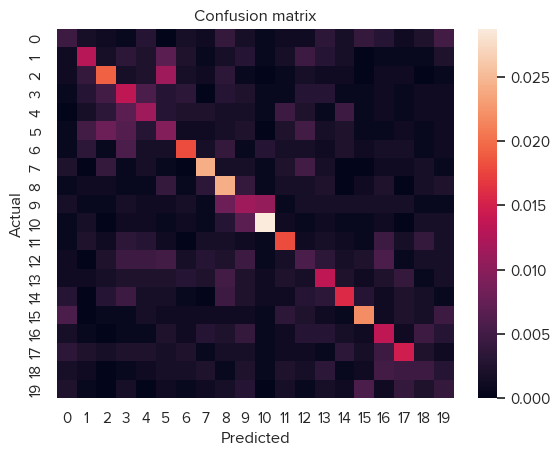

In [25]:
np.random.seed(1)
tree_numerical = classif.ClassifierArbreNumerique(news_desc.shape[1], epsilon=0.0)

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(tree_numerical, (news_desc.toarray(), news_labels), 5, True, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

### **Vectorisation avec TF-IDF**

In [26]:
news_labels = news_no_stopwords["target"].values
n_classes = news_no_stopwords["target"].nunique()

news_desc = get_tfidf_vect(news_no_stopwords, corpus)
news_desc.shape

(1815, 3284)

##### KNN multi-classe [distance **euclidienne**] k = 1

Results [0.23943661971830985, 0.21971830985915494, 0.2676056338028169, 0.2056338028169014, 0.2]
Mean accuracy 0.2265, std : 0.0247
Time 1.1493220329284668


Text(0.5, 1.0, 'Confusion matrix')

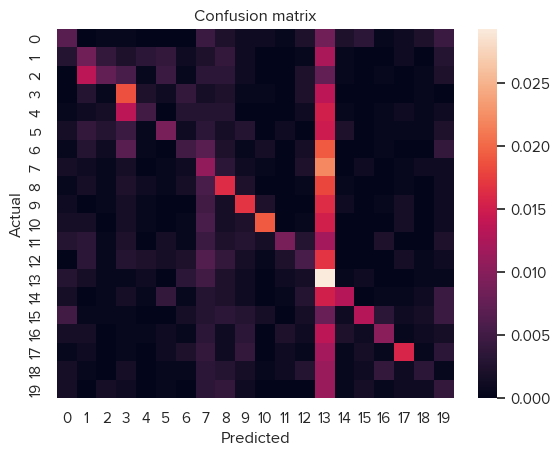

In [27]:
np.random.seed(1)
classifier_knn = classif.ClassifierKNN_MC(news_desc.shape[1], k=1, C=n_classes, dist_type="euclidean")

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(classifier_knn, (news_desc, news_labels), 5, False, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

##### KNN multi-classe [distance **cosinus**] k = 13

Results [0.5746478873239437, 0.5183098591549296, 0.5295774647887324, 0.5464788732394367, 0.5605633802816902]
Mean accuracy 0.5459, std : 0.0203
Time 1.7517421245574951


Text(0.5, 1.0, 'Confusion matrix')

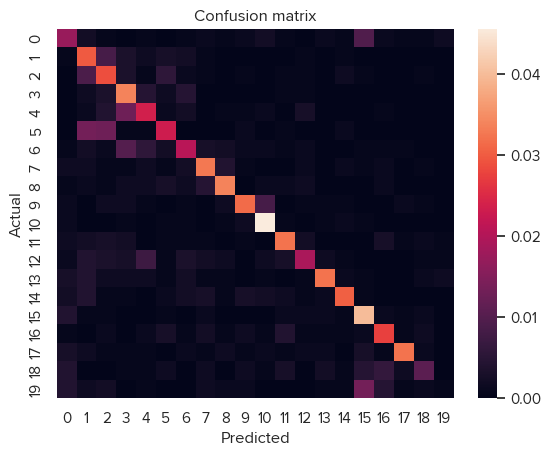

In [28]:
np.random.seed(1)
classifier_knn = classif.ClassifierKNN_MC(news_desc.shape[1], k=13, C=n_classes, dist_type="cosine")

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(classifier_knn, (news_desc, news_labels), 5, False, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

##### Perceptron

Results [0.49859154929577465, 0.4676056338028169, 0.4732394366197183, 0.4507042253521127, 0.5098591549295775]
Mean accuracy 0.4800, std : 0.0214
Time 102.53988194465637


Text(0.5, 1.0, 'Confusion matrix')

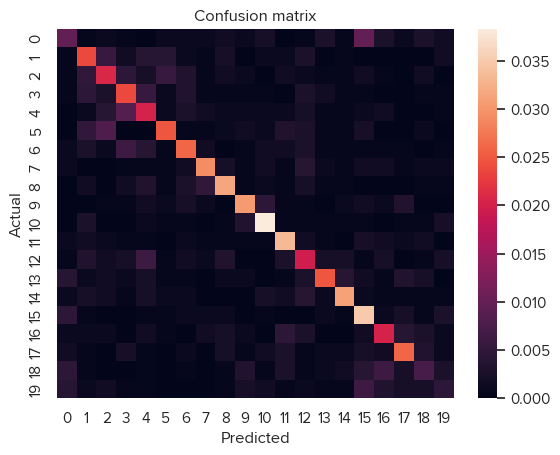

In [29]:
np.random.seed(1)
classifier_perc = classif.ClassifierPerceptron(news_desc.shape[1], 0.01, init=False)
perc_mcc = classif.ClassifierMultiOAA(classifier_perc, classes = np.unique(news_labels))

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(perc_mcc, (news_desc, news_labels), 5, False, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

##### Arbre numérique
Trop long (1 itération 80% train, 20% test ~20 min)

In [167]:
np.random.seed(1)
tree_numerical = classif.ClassifierArbreNumerique(news_desc.shape[1], epsilon=0.0)

start = time.time()
(res_all, res_mean, res_std, conf_matrix_mean) = ev.validation_croisee(tree_numerical, (news_desc.toarray(), news_labels), 5, True, True)
end = time.time()

print("Results", res_all)
print(f"Mean accuracy {res_mean:.4f}, std : {res_std:.4f}")
print("Time", end - start)
ax = sns.heatmap(conf_matrix_mean)
ax.set_title("Confusion matrix")

------ affichage validation croisée
Itération 0: taille de base app.=1478	taille base test=359	Taux de bonne classif: 0.2758


KeyboardInterrupt: 

## Tâches à réaliser

### Apprentissage supervisé

*Tâches*: évaluation d'algorithmes et de représentations des données.
- classification binaire
- classification multi-classe

*Etudes suggérées*:
- représentations des données
    - avec ou sans suppression des stopwords
    - différentes représentations: bag-of-words binaire, avec comptage, avec fréquences, avec tfidf
- différents classifiers:
    - perceptron,
    - k-plus proches voisins avec distance euclidienne,
    - k-plus proches voisins avec distance cosinus (cf. TD),
    - Naives Bayes,
    - arbres de décision
- analyse des résultats:
    - accuracy, temps d'exécutions
    - score fold par fold
    - matrice de confusion


### Apprentissage non-supervisé

*Tâche*: vérifier que le découpage a du sens par rapport aux groupes fournis. 

*Etudes suggérées*:
- étudier l'application d'un clustering hiérarchique et son résultat;
- étudier les résultats de l'application de l'algorithme des k-moyennes, pour différentes valeurs de k;
- proposer des évaluations des clusters trouvés afin de mettre en évidence les plus intéressants:
    - en utilisant les indices d'évaluation présentés en cours;
    - en comparant par diverses méthodes les clusters trouvés avec les vrais labels des classes (targets y).
- proposer une visualisation des résultats obtenus


   


## Poster à rendre dans le compte-rendu (format PDF)

Votre poster doit décrire de façon synthétique **l'ensemble des expérimentations** menées sur les données, les résultats obtenus en apprentissage supervisé et en apprentissage non-supervisé ainsi que les conclusions/bilans que vous tirez de ces expérimentations (ie. ce que vous avez appris sur ces données).

*Remarque*: vous devez indiquer vos noms/prénoms et groupe (1, 2, ou 3) sur le poster.
